<a href="https://colab.research.google.com/github/nazzang49/kaggle-practice/blob/main/DL02_Flower_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Recognition

## Load Packages

In [1]:
!nvidia-smi

Sat Aug  7 16:15:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
# import visdom

In [3]:
# !pip install visdom

In [4]:
# from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Visualization

In [5]:
# '''
#     For Visualizing Loss Function Graph
# '''
# vis = visdom.Visdom()
# vis.close(env='main')

In [6]:
# '''
#     Args:
#         value_plot: type of graph
#         value: loss value
#         num: each epochs
# '''
# def value_tracker(value_plot, value, num):
#     vis.line(X=num, Y=value, win=value_plot, update='append') # update append => can tracking changes of loss

## Set Device

In [7]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [8]:
# import torch_xla
# import torch_xla.core.xla_model as xm

# device = xm.xla_device()
# device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed(777)

device

'cuda'

## Load Dataset

### Get Images and Set Transform

In [9]:
from torchvision.datasets import ImageFolder

root = '/content/drive/MyDrive/data/flowers/'

# original and augmentation
transformer = {
    'original': transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.ToTensor(), 
                                 transforms.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
]), 
   'dataset1': transforms.Compose([
                           transforms.Resize((220, 220)),
                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transforms.RandomRotation(5),
                           transforms.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                               (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)),
]), 
   'dataset2': transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                 transforms.ToTensor(),
                                 transforms.RandomErasing(inplace=True, scale=(0.01, 0.23)),
                                 transforms.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))]),
   'dataset3': transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomRotation(15),
                                 transforms.RandomAffine(translate=(0.08,0.1), degrees=15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
                                                     
])
       }

### Train and Test Split

In [10]:
from torch.utils.data import DataLoader, Dataset, ConcatDataset

original = ImageFolder(root, transform=transformer['original'])

# original => train_val (8) + test (2)
train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

# train_val => train + val + dataset1 + dataset2 + dataset3 (augmentation)
train_val = ConcatDataset([train_val, 
                           ImageFolder(root, transform=transformer['dataset1']),
                           ImageFolder(root, transform=transformer['dataset2']),
                           ImageFolder(root, transform=transformer['dataset3'])]) 

train, val = train_test_split(train_val, test_size=0.1, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=64, num_workers=4, pin_memory=True),
    'val': DataLoader(val, batch_size=64, num_workers=4, pin_memory=True),
    'test': DataLoader(test, batch_size=64, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val), 
    'test': len(test)
}

dataset_sizes

{'test': 864, 'train': 14763, 'val': 1641}

### Check Image

In [11]:
# check image norm
def plotHist(image):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.axis('off')
  histo = plt.subplot(1, 2, 2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(image.flatten(), bins=10, lw=0, alpha=0.5, color='r')

In [12]:
import matplotlib.pyplot as plt

'''
    transpose reason: change axis from torch to matplotlib
    
        torch:
            [batch_size, channel, width, height]
        matplotlib:
            [width, height, channel]
'''
def check_iamge(image):
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    plotHist(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)
tensor(3)
tensor(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
tensor(4)
tensor(3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)
tensor(4)
tensor(2)
tensor(4)
tensor(1)


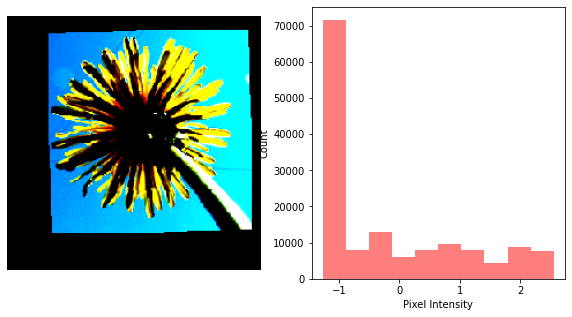

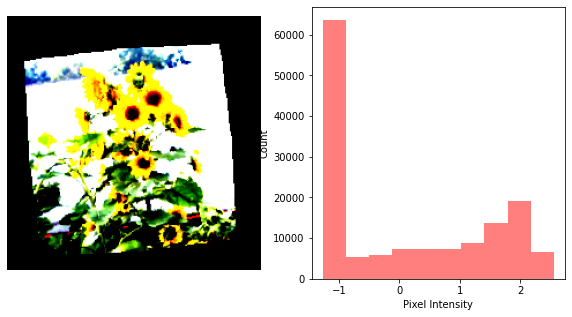

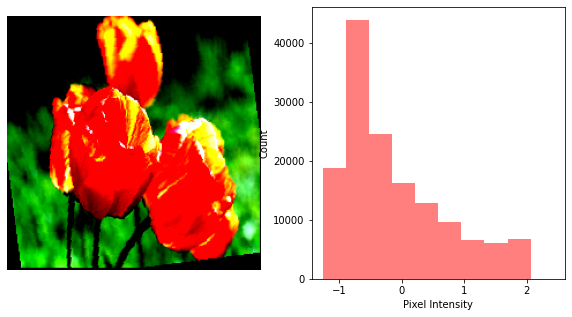

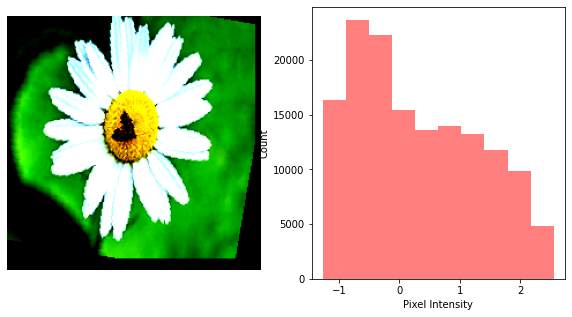

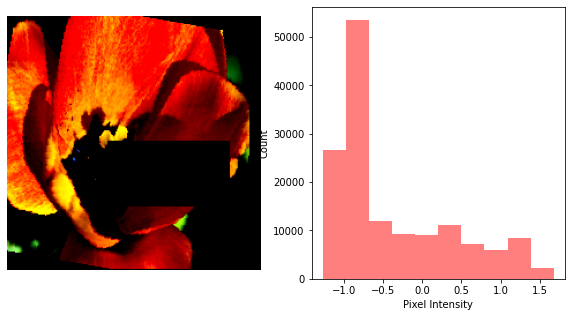

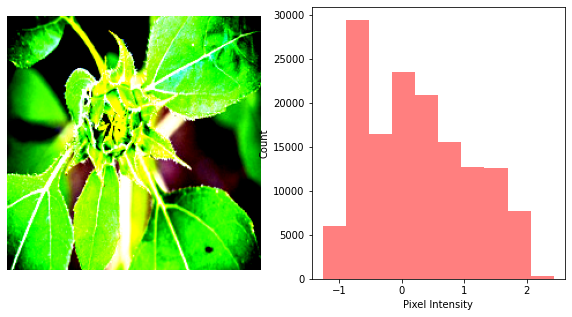

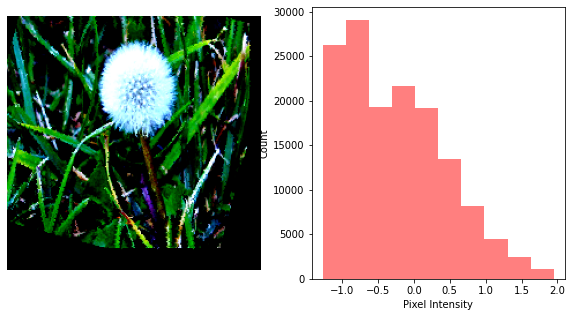

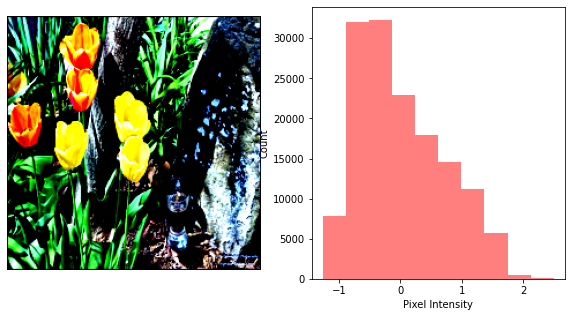

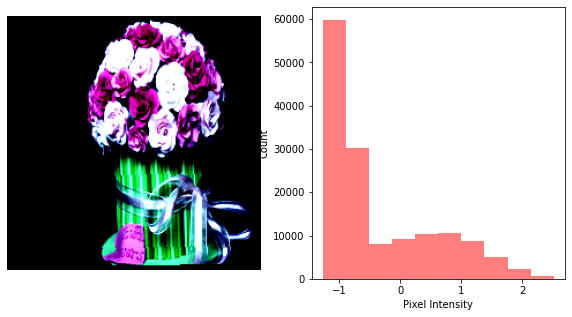

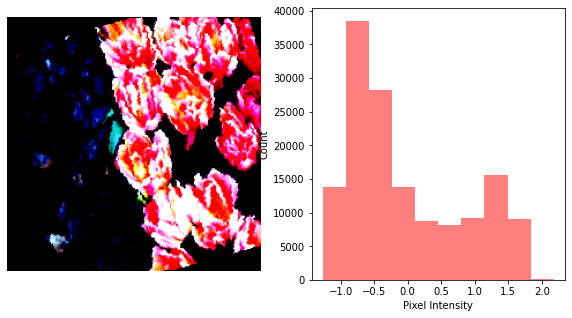

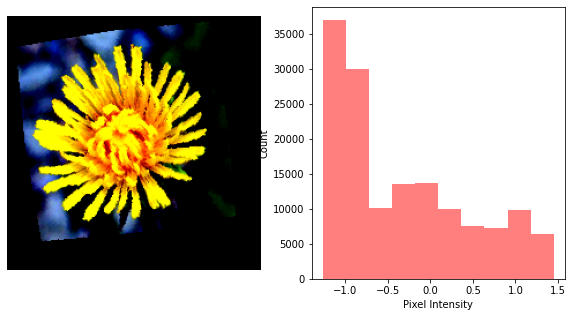

In [13]:
# check 10-images
for i, (images, labels) in enumerate(loaders['train']):
    check_iamge(images[0])
    print(labels[0]) # index of flower folder
    if i == 10:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


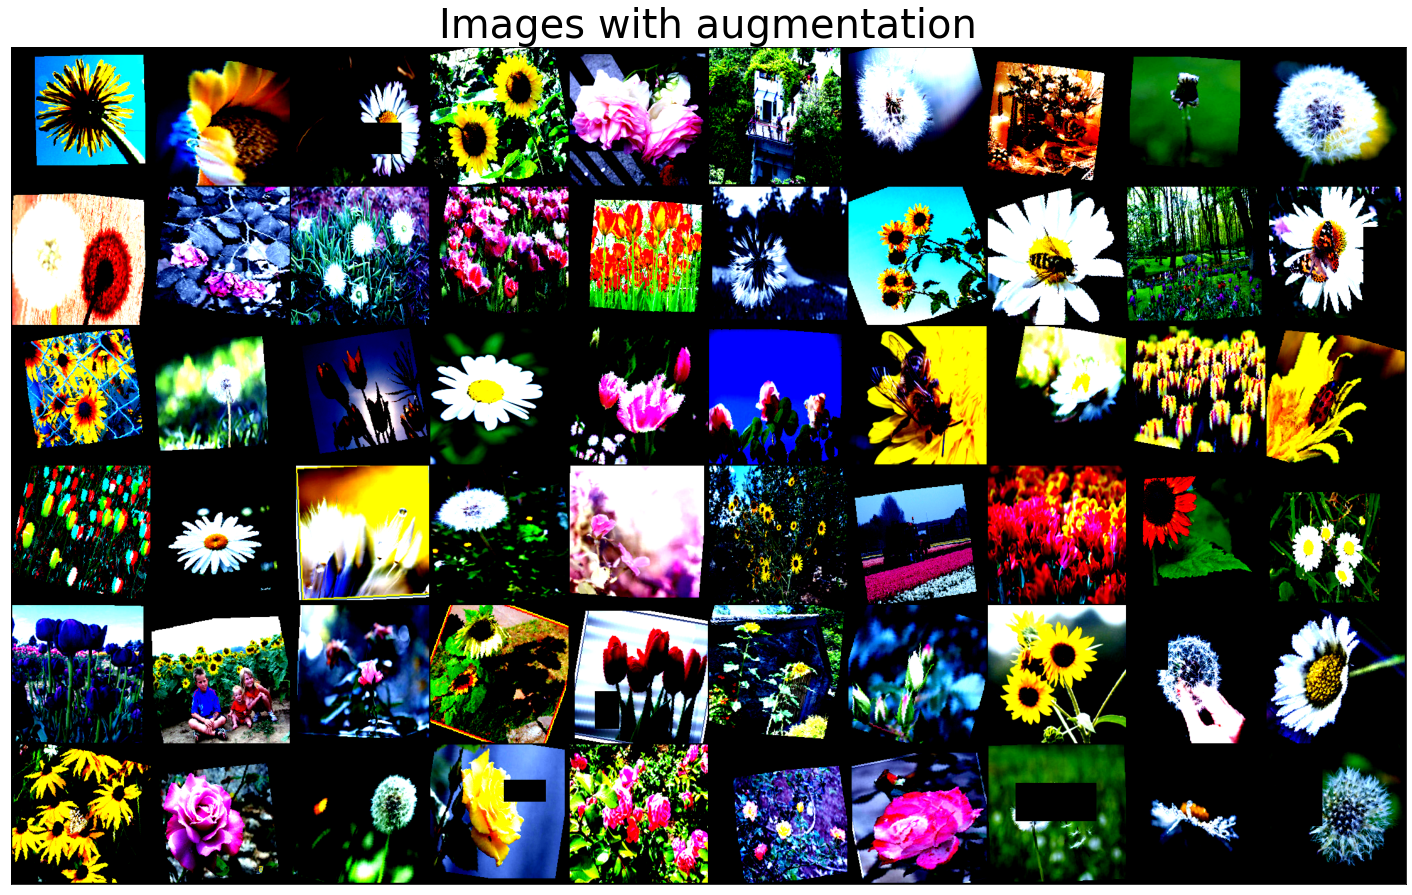

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

## ResNet Architecture

In [15]:
import torchvision.models.resnet as resnet

### ResNet50 and ResNet152

In [16]:
resnet50 = resnet.resnet50(pretrained=True).to(device)
resnet152 = resnet.resnet152(pretrained=True).to(device)

### Train Function

In [34]:
def training(model):
  
  global best_acc
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)

  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)        # running_loss = summation of loss per batch_size
        running_corrects += torch.sum(pred == labels.data)  # running_corrects = num of corrects per batch_size

      # train acc
      if phase == 'train':
        acc = 100. * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]                      # epoch_loss = mean of loss per epoch
      epoch_acc = 100 * running_corrects.double() / dataset_sizes[phase]    # epoch_acc = percentage of corrects per epoch

      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch + 1, epochs))

      # result of train and val
      print('{} - Loss: {}, Acc: {}%'.format(phase.title(), epoch_loss, epoch_acc))
    
      # if better model => save
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f'/content/drive/MyDrive/model/model_epoch_{epoch}.pth')

### Train

In [22]:
training(resnet152)

Epoch: 1/10
train - Loss: 0.7485208890992501, Acc: 71.36083451872926
val - Loss: 0.6472870100932031, Acc: 76.1121267519805
Epoch: 2/10
train - Loss: 0.4877079120033892, Acc: 82.35453498611393
val - Loss: 0.514621208093284, Acc: 81.90127970749543
Epoch: 3/10
train - Loss: 0.3356504124721553, Acc: 88.09185124974599
val - Loss: 0.4413045772250871, Acc: 84.46069469835467
Epoch     4: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4/10
train - Loss: 0.22614604825750603, Acc: 92.02736571157624
val - Loss: 0.41235908682501804, Acc: 86.89823278488727
Epoch: 5/10
train - Loss: 0.1328275557567038, Acc: 95.6174219332114
val - Loss: 0.2887176899358603, Acc: 90.43266301035955
Epoch: 6/10
train - Loss: 0.08288113350099255, Acc: 97.6088870825713
val - Loss: 0.28764517096794645, Acc: 90.61547836684949
Epoch     7: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 7/10
train - Loss: 0.058059396435145356, Acc: 98.48269321953532
val - Loss: 0.30144291432400727, Acc: 90.6764168190128
Epoch:

### Test

In [31]:
def test_predict(model, test_loader):
  total = 0
  correct = 0

  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)

      outp = model(images)
      _, pred = torch.max(outp.data, 1)

      total += images.size(0)
      correct += torch.sum(pred == labels.data)

    acc = 100 * correct / total
    print(f'Test Acc: {acc:.6f}%')

In [32]:
test_predict(resnet152, loaders['test'])

Test Acc: 93.518517%
